In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys

%matplotlib inline

# !jupyter nbconvert --to script rec.ipynb

# Init data sizes and parametes of the PXM of ID16A

In [2]:
# cp.cuda.Device(int(sys.argv[1])).use()
# ntheta = int(sys.argv[2])#750  # number of angles (rotations)
# ptheta = int(sys.argv[3])  # holography chunk size for GPU processing
# binning = int(sys.argv[4])
# niter = int(sys.argv[5])
# iter_step = int(sys.argv[6])
# same_probe = sys.argv[7]=='True'
# rand = sys.argv[8]
# shifts_probe_flg = sys.argv[9]=='True'
# st = int(sys.argv[10])

# flg_show = False

cp.cuda.Device(0).use()
ntheta = 10  # number of angles (rotations)
ptheta = 10  # holography chunk size for GPU processing
binning = 0
niter = 33
iter_step = 8
flg_show = True
same_probe = True
rand = 'norand'
shifts_probe_flg = True
st = 0
flg_show = True


if shifts_probe_flg==True and rand=='rand':
    shifts_probe = np.array([[0.   ,0.  ], [0.0542, 0.0775], [0.307, 0.4144],[0.7067, 0.67]]).astype('float32')        
elif shifts_probe_flg==True and rand=='norand':
    shifts_probe = np.array([[0.   ,0.  ], [0.07, 0.016], [0.447, 0.291],[0.892, 0.525]]).astype('float32')        
elif shifts_probe_flg==False:
    shifts_probe = None
print(f'{shifts_probe=}')    
    
cropx_left = 512
cropx_right = 512
cropy_up =0
cropy_down = 1024
n = (2048-cropx_left-cropx_right)//2**binning
print(n)
pn = 32  # tomography chunk size for GPU processing

center = n/2  # rotation axis

# ID16a setup
detector_pixelsize = 3e-6
energy = 17.05 #[keV] xray energy
focusToDetectorDistance = 1.2081 # [m]
ndist = 4
sx0 = -2.41e-3
#z1 = np.array([1.5335e-3,1.7065e-3,2.3975e-3,3.8320e-3])[:ndist]-sx0
z1 = np.array([17.723e-3,18.587e-3,22.041e-3,29.215e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2**binning  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2
# norm_magnifications[:] = 1

shifts_probe=array([[0.    , 0.    ],
       [0.0542, 0.0775],
       [0.307 , 0.4144],
       [0.7067, 0.67  ]], dtype=float32)
1024


## Read data

In [3]:
data0 = np.zeros([ndist,ntheta,n,n],dtype='float32')
ref0 = np.zeros([ndist,n,n],dtype='float32')
dark0 = np.zeros([1,n,n],dtype='float32')

# theta = np.loadtxt(f'/data/viktor/id16a/zysset_s4/zysset_s4_rand_50nm_/angles_file.txt').astype('float32')[:][:1500:1500//ntheta]
# print(f'{theta=}')
for k in range(ndist):
    for j in range(0,ntheta):
        # print(j)
        jtheta=st+j
        fname = f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_{k+1}_/zysset_s4_{rand}_50nm_{k+1}_{jtheta:04}.edf'
        tmp = dxchange.read_edf(fname)[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
        for kb in range(binning):
            tmp = (tmp[::2]+tmp[1::2])/2
            tmp = (tmp[:,::2]+tmp[:,1::2])/2
        data0[k,j] = tmp

    tmp = dxchange.read_edf(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_{k+1}_/refHST0000.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
    for kb in range(binning):
        tmp = (tmp[::2]+tmp[1::2])/2
        tmp = (tmp[:,::2]+tmp[:,1::2])/2
    ref0[k] = tmp

tmp = dxchange.read_edf(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_1_/dark.edf')[0,cropy_up:2048-cropy_down,cropx_left:2048-cropx_right]
for kb in range(binning):
    tmp = (tmp[::2]+tmp[1::2])/2
    tmp = (tmp[:,::2]+tmp[:,1::2])/2
dark0[:] = tmp

mean_all = np.mean(data0[:,:,0:n//16,0:n//16])

mean_each = np.mean(data0[:,:,0:n//16,0:n//16],axis=(2,3))
data0 = data0*mean_all/mean_each[:,:,np.newaxis,np.newaxis]

ref0_mean = np.mean(ref0[:,0:n//16,0:n//16],axis=(1,2))
ref0 = ref0*mean_all/ref0_mean[:,np.newaxis,np.newaxis]


ValueError: could not broadcast input array from shape (1536,1024) into shape (1024,1024)

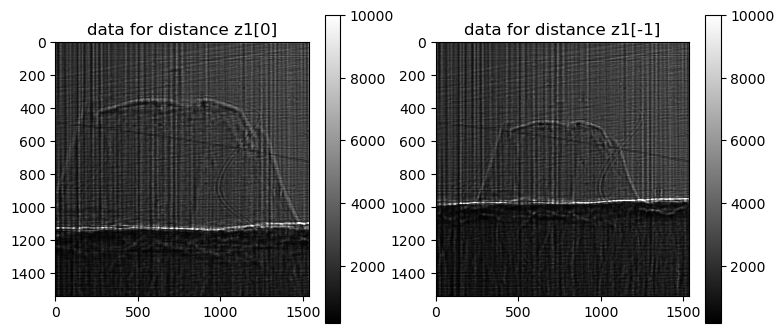

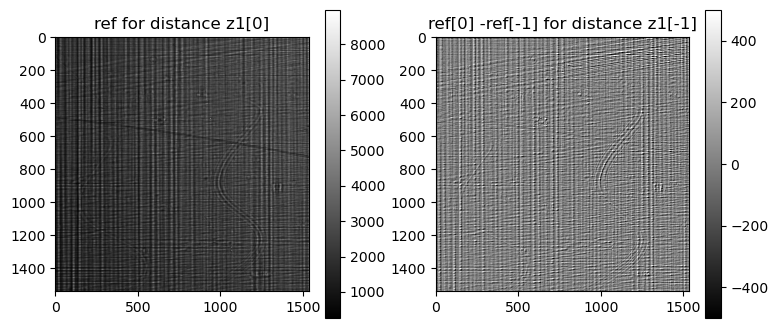

In [ ]:
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(data0[0,0],cmap='gray',vmax=10000)
    axs[0].set_title('data for distance z1[0]')
    fig.colorbar(im)
    im=axs[1].imshow(data0[-1,0],cmap='gray',vmax=10000)
    axs[1].set_title('data for distance z1[-1]')
    fig.colorbar(im)

    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    im=axs[0].imshow(ref0[0],cmap='gray')
    axs[0].set_title('ref for distance z1[0]')
    fig.colorbar(im)
    im=axs[1].imshow(ref0[0]-ref0[-1],cmap='gray',vmin=-500,vmax=500)
    axs[1].set_title('ref[0] -ref[-1] for distance z1[-1]')
    fig.colorbar(im)

# use second ref
# ref0 = ref0[1:2]#np.mean(ref0,axis=0)[np.newaxis]

# Dark-flat field correction

In [ ]:

rdata = (data0-dark0[:,np.newaxis])
rref = ref0-dark0
rref[rref<0] = 0
rdata[rdata<0]=0
rdata/=(rref[:,np.newaxis]+1e-9)
for k in range(ndist):
    dxchange.write_tiff(rdata[k],f'/data/viktor/tmp/tn{k}.tiff',overwrite=True)
for k in range(ndist):
    dxchange.write_tiff(data0[k]/ref0[k],f'/data/viktor/tmp/dn{k}.tiff',overwrite=True)

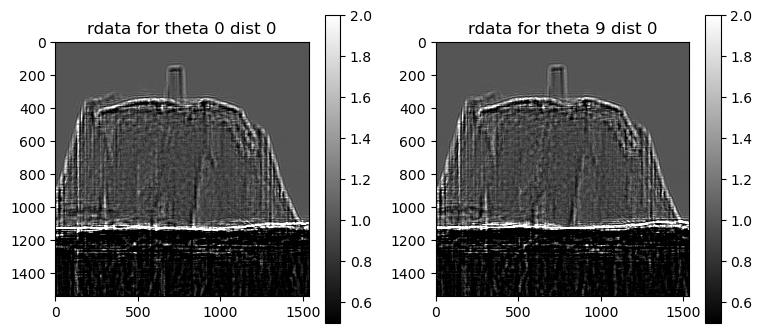

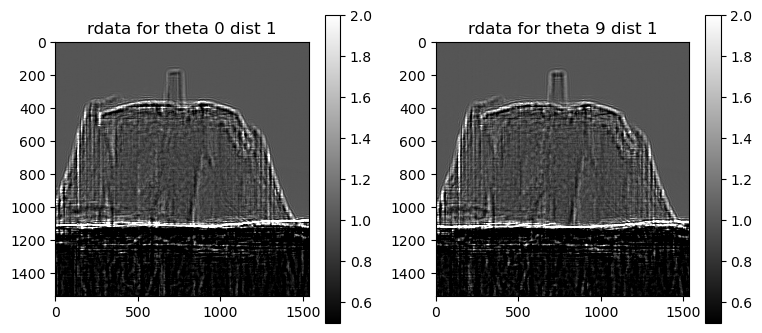

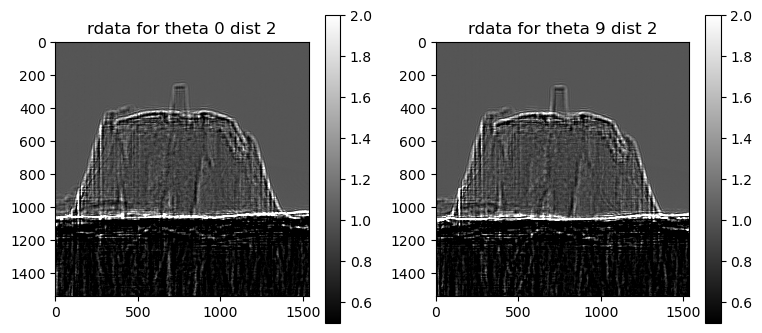

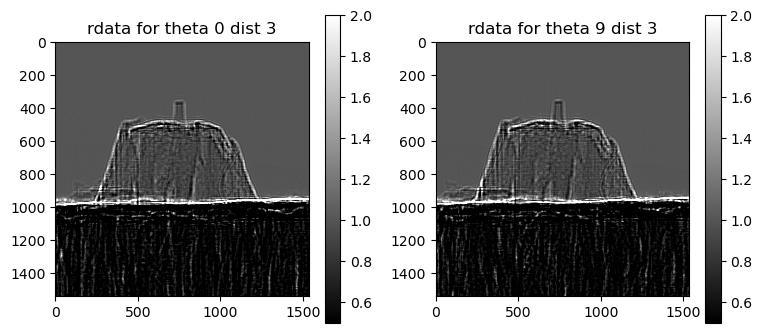

In [ ]:
if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        im=axs[0].imshow(rdata[k,0],cmap='gray',vmin = 0.5,vmax=2 )
        axs[0].set_title(f'rdata for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata[k,-1],cmap='gray',vmin = 0.5,vmax=2)
        axs[1].set_title(f'rdata for theta {ntheta-1} dist {k}')
        fig.colorbar(im)

In [ ]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    print(shift.shape,tmp.shape)
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_random = np.zeros([ndist,ntheta,2],dtype='float32')
for k in range(ndist):
    if rand=='rand':
        s = np.loadtxt(f'/data/viktor/id16a/zysset_s4/zysset_s4_{rand}_50nm_{k+1}_/correct.txt').astype('float32')[st:st+ntheta]/norm_magnifications[k]
    else:
        s = np.zeros([ntheta,2],dtype='float32')#np.loadtxt(f'/data/viktor/id16a/zysset_s4/zysset_s4_norand_50nm_{k+1}_/correct.txt').astype('float32')[:1500:1500//ntheta]/norm_magnifications[k]    
    shifts_random[k,:,0] = s[:,1]+(1024-(2048-cropy_down)/2)*(1/norm_magnifications[k]-1)#/norm_magnifications[k]
    shifts_random[k,:,1] = s[:,0]
shifts_dist = np.zeros([ndist,ntheta,2],dtype='float32')
rdata_shifted=rdata.copy()
rdata_scaled=rdata.copy()
for j in range(ntheta):
    for k in range(0,ndist):#!!!!!!!!!!!!!!
        rdata_shifted[k,j:j+1] = apply_shift(rdata[k,j:j+1],-shifts_random[k,j:j+1]/2**binning*norm_magnifications[k])# note first shift then magnification    
        a = ndimage.zoom(rdata_shifted[k,j],1/norm_magnifications[k])
        rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]        
        shifts_dist[k,j] = registration_shift(rdata_scaled[k,j:j+1],rdata_scaled[0,j:j+1],upsample_factor=10)
        print(f'{k} {j}: {shifts_random[k,j:j+1]/2**binning} {shifts_dist[k,j]}')
  

(1, 3072, 1537) (1, 3072, 3072)
0 0: [[0. 0.]] [0. 0.]
(1, 3072, 1537) (1, 3072, 3072)
1 0: [[10.986142  0.      ]] [-13.8  -5.2]
(1, 3072, 1537) (1, 3072, 3072)
2 0: [[54.90528  0.     ]] [-61.4  22.9]
(1, 3072, 1537) (1, 3072, 3072)
3 0: [[146.12587   0.     ]] [-181.    15.8]
(1, 3072, 1537) (1, 3072, 3072)
0 1: [[-1.1075 10.3942]] [0. 0.]
(1, 3072, 1537) (1, 3072, 3072)
1 1: [[1.0471659 7.294322 ]] [-14.2  -5. ]
(1, 3072, 1537) (1, 3072, 3072)
2 1: [[52.03102     0.18925509]] [-61.1  22.7]
(1, 3072, 1537) (1, 3072, 3072)
3 1: [[152.94579    9.144704]] [-181.8   14.5]
(1, 3072, 1537) (1, 3072, 3072)
0 2: [[-0.0383333 -5.18333  ]] [0. 0.]
(1, 3072, 1537) (1, 3072, 3072)
1 2: [[-1.0438776 -6.830225 ]] [-14.   -5.2]
(1, 3072, 1537) (1, 3072, 3072)
2 2: [[50.166805 -9.65203 ]] [-61.  23.]
(1, 3072, 1537) (1, 3072, 3072)
3 2: [[144.78938  -1.79334]] [-181.3   14.7]
(1, 3072, 1537) (1, 3072, 3072)
0 3: [[7.37583 6.90917]] [0. 0.]
(1, 3072, 1537) (1, 3072, 3072)
1 3: [[ 13.555185 -11.72934

# Total shifts in pixels before normalized scaling

[[[  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]
  [  -0.           -0.        ]]

 [[ -13.18564028  -23.979898  ]
  [ -13.18532337  -23.97865424]
  [ -13.18500796  -23.97739245]
  [ -13.18469403  -23.97611271]
  [ -13.1843816   -23.97481507]
  [ -13.18407065  -23.97349958]
  [ -13.1837612   -23.97216631]
  [ -13.18345324  -23.97081532]
  [ -13.18314677  -23.96944665]
  [ -13.18284178  -23.96806038]]

 [[ -57.14653242    6.6561539 ]
  [ -57.14669638    6.65813098]
  [ -57.14686111    6.66012945]
  [ -57.14702663    6.66214905]
  [ -57.14719292    6.66418955]
  [ -57.14736       6.66625072]
  [ -57.14752785    6.66833232]
  [ -57.14769648    6.67043413]
  [ -57.14786588    6.6725559 ]
  [ -57.14803607    6.67469741]]

 [[-165.78194375    6.00055229]
  

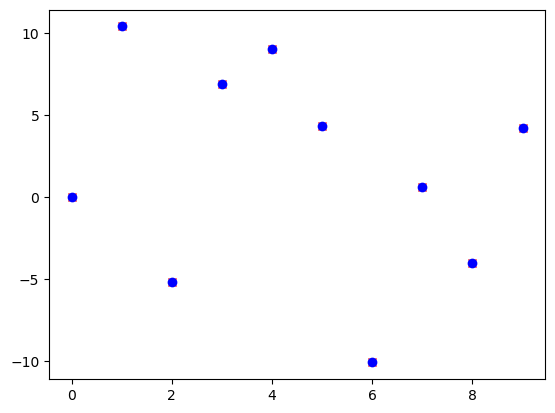

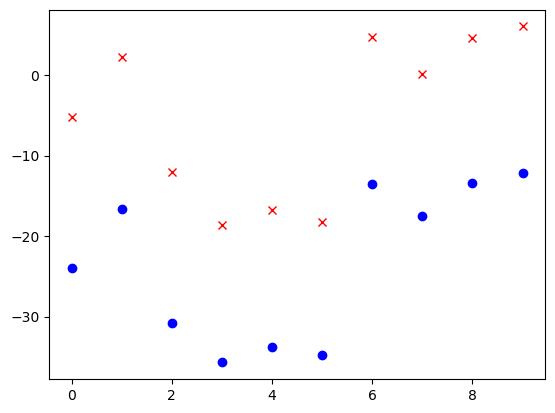

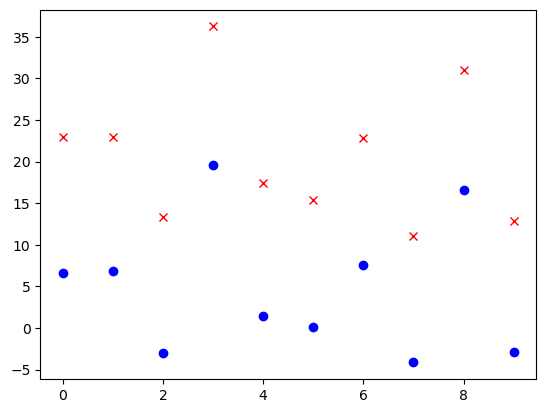

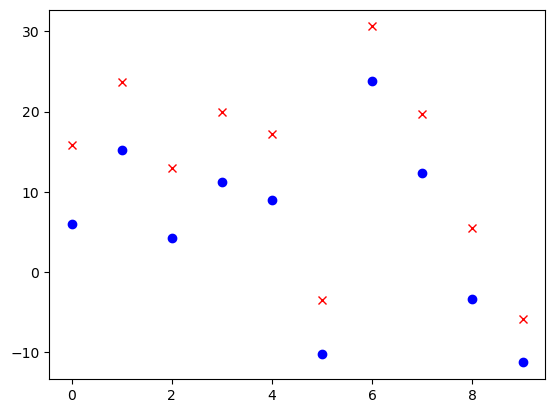

In [ ]:

import scipy.io 
shifts_new = -scipy.io.loadmat(f'/data/viktor/id16a/zysset_s4/zysset_s4_norand_50nm_/rhapp_py.mat')['rhapp'][:,:,st:st+ntheta].swapaxes(0,2).swapaxes(0,1)[:ndist]

print(shifts_new)
shifts_new+=shifts_random
shifts_new/=2**binning
# shifts_new*=norm_magnifications[:,np.newaxis,np.newaxis]


shifts = (shifts_dist+shifts_random/2**binning)#*norm_magnifications[:,np.newaxis,np.newaxis]# cannot be combined with 

if flg_show:
    for k in range(ndist):
        plt.figure()
        plt.plot(shifts[k,:,1],'rx')
        plt.plot(shifts_new[k,:,1],'bo')

# take shifts from Peter
shifts = shifts_new


# TEST: Scale initial data to 1 magnification and apply all shifts

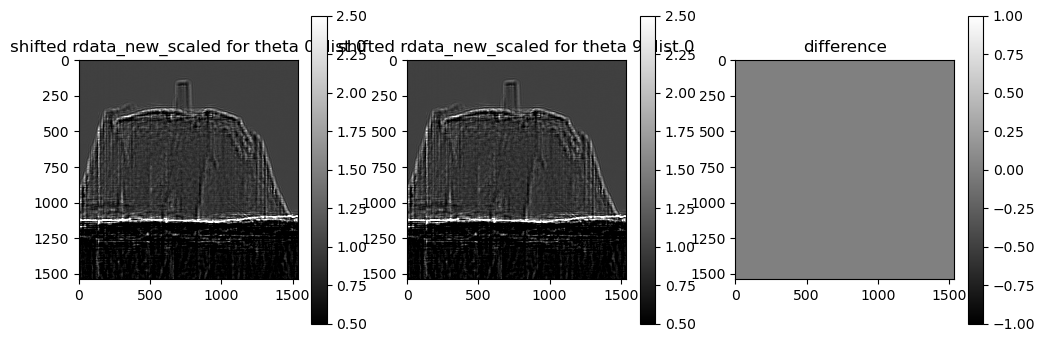

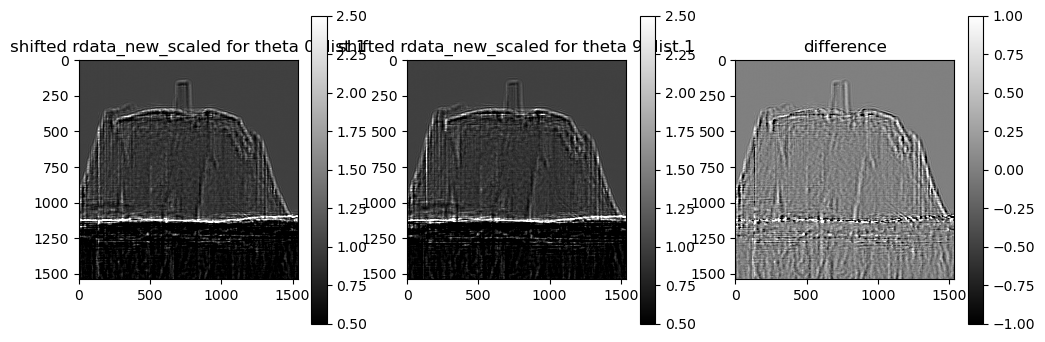

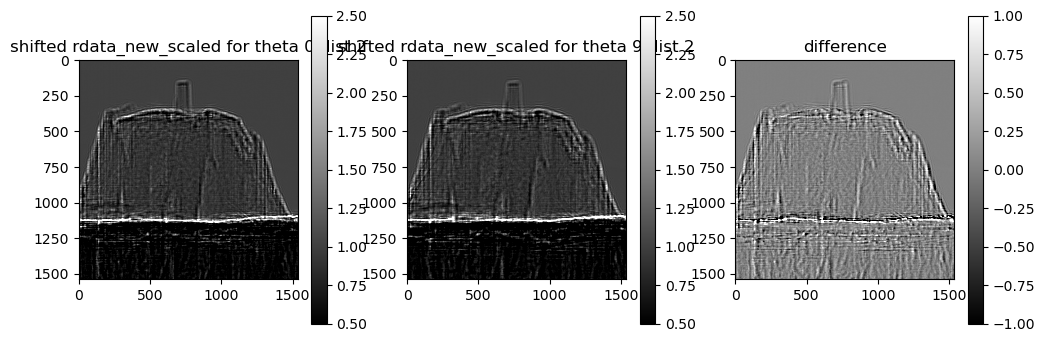

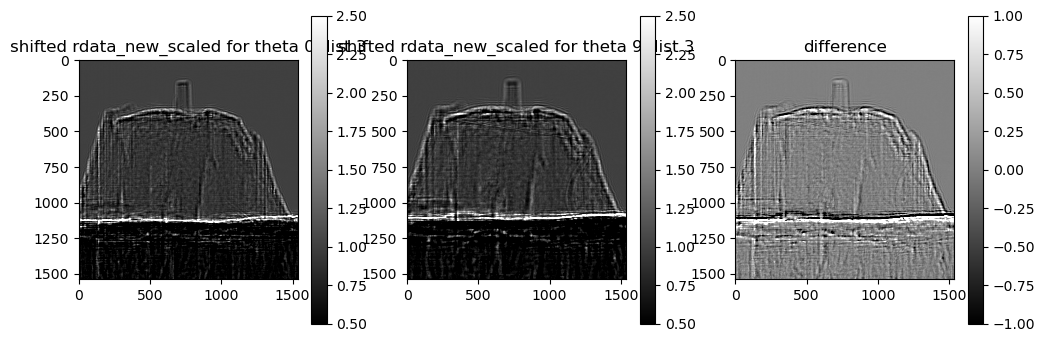

In [ ]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res
rdata_scaled_new = rdata.copy()
for j in range(ntheta):
    
    for k in range(ndist):    
        a = apply_shift(rdata[k,j:j+1],-shifts[k,j:j+1]*norm_magnifications[k,np.newaxis,np.newaxis])[0]# note first shift then magnification
        a = ndimage.zoom(a,1/norm_magnifications[k])
        rdata_scaled_new[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]  

if flg_show:
    for k in range(ndist):
        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        im=axs[0].imshow(rdata_scaled_new[0,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[0].set_title(f'shifted rdata_new_scaled for theta 0 dist {k}')
        fig.colorbar(im)
        im=axs[1].imshow(rdata_scaled_new[k,0],cmap='gray',vmin = 0.5,vmax=2.5 )
        axs[1].set_title(f'shifted rdata_new_scaled for theta {ntheta-1} dist {k}')
        fig.colorbar(im)        
        im=axs[2].imshow(rdata_scaled_new[0,0]-rdata_scaled_new[k,0],cmap='gray',vmin =-1,vmax=1 )
        axs[2].set_title(f'difference')
        fig.colorbar(im)          
    

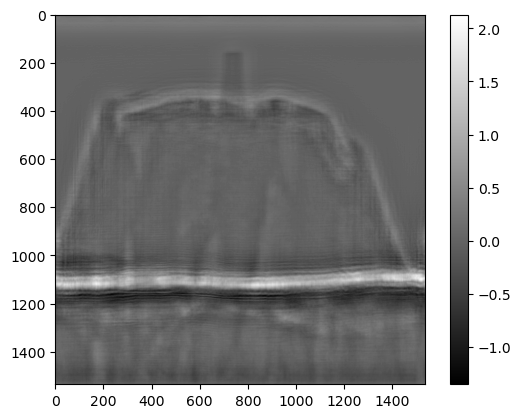

In [ ]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase


distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recCTFPurePhase = np.zeros([ntheta,n,n],dtype='complex64')
for k in range(ntheta):
    rads = rdata_scaled_new[:ndist,k]
    recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-2))
if flg_show:
    plt.imshow(np.angle(recCTFPurePhase[-1]),cmap='gray')
    plt.colorbar()
dxchange.write_tiff(np.angle(recCTFPurePhase),f'/data/vnikitin/holo/zysset_s4/shift_probe{shifts_probe_flg}_{rand}_r{n}_{ntheta}_{ndist}_{st}/CTF.tiff',overwrite=True)



In [ ]:
#raise Exception

## Create a solver class for holography

In [ ]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications,distances2,same_probe=same_probe)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Adjoint test

In [ ]:
data = data0.copy()
ref = ref0.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
# if same_probe==True:
    # prb1[:] = prb1[0]
shifts_ref = shifts[:]
print(arr1.shape,prb1.shape,shifts_ref.shape,ref.shape)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts_ref,shifts_probe=shifts_probe)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts_ref,shifts_probe=shifts_probe)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts_ref,shifts_probe=shifts_probe)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))


(10, 3072, 3072) (4, 1536, 1536) (4, 10, 2) (4, 1536, 1536)
(1.1932713e+22+1012712600000000j)
(1.1932747e+22-14984928000j)
(1.1912711e+22+1.4554972e+18j)


## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi_i))|-\sqrt{\text{I}_{ij}}\|^2_2 + \||\mathcal{G}_{d_0}q|-\sqrt{\text{I}_r}\|_2^2\to \text{min}_{\psi_i,q}$ 

In [14]:
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma

from holotomo.utils import chunk
# def adj_holo_batch_ext(pslv):
def adj_holo_batch_ext(pslv,fpsi, data, prb, shifts=None, code=None, shifts_code=None,shifts_probe=None):
    """Batch of Holography transforms"""
    res = np.zeros([ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_gpu = cp.array(prb)
    shifts_gpu = None        
    shifts_code_gpu = None
    code_gpu = None
    shifts_probe_gpu = None
    if code is not None:
        code_gpu = cp.array(code)   
    if shifts_probe is not None:
        shifts_probe_gpu = cp.array(shifts_probe)
    for ids in chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        fpsi_gpu = cp.array(fpsi[:, ids])
        data_gpu = cp.array(data[:, ids])
            
        if shifts is not None:
            shifts_gpu = cp.array(shifts[:,ids])
        if shifts_code is not None:
            shifts_code_gpu = cp.array(shifts_code[:,ids])
        fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))        
        # Radon transform
        res_gpu = -pslv.adj_holo(fpsi_gpu, prb_gpu, shifts_gpu, code_gpu, shifts_code_gpu,shifts_probe_gpu)
        # copy result to cpu
        res[ids] = res_gpu.get()
    return res

def adj_holo_prb_batch_ext(pslv, fpsi, data, psi, shifts=None, code=None, shifts_code=None,shifts_probe=None):
        """Batch of Holography transforms"""
        res = np.zeros([len(pslv.distances), pslv.n, pslv.n], dtype='complex64')
        shifts_gpu = None        
        shifts_code_gpu = None
        code_gpu = None
        shifts_probe_gpu = None
        if code is not None:
            code_gpu = cp.array(code)   
        if shifts_probe is not None:
            shifts_probe_gpu = cp.array(shifts_probe)
        for ids in chunk(range(pslv.ntheta), pslv.ptheta):
            # copy data part to gpu
            fpsi_gpu = cp.array(fpsi[:, ids])
            psi_gpu = cp.array(psi[ids])
            data_gpu = cp.array(data[:, ids])
            
            if shifts is not None:
                shifts_gpu = cp.array(shifts[:,ids])
            if shifts_code is not None:
                shifts_code_gpu = cp.array(shifts_code[:,ids])
            # Radon transform
            fpsi_gpu = fpsi_gpu-data_gpu*cp.exp(1j*(np.angle(fpsi_gpu)))                
            # fprb-data*np.exp(1j*np.angle(fprb))
            res_gpu = -pslv.adj_holo_prb(fpsi_gpu, psi_gpu, shifts_gpu,code_gpu,shifts_code_gpu,shifts_probe_gpu)
            # copy result to cpu
            res += res_gpu.get()
        return res

import time
def cg_holo_batch2(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts,shifts_probe,upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""

    data = np.sqrt(data)
    data_ref = np.sqrt(data_ref)
    
    # minimization functional
    def minf(fpsi,fprb):
        f = np.linalg.norm(np.abs(fpsi)-data)**2            
        f += np.linalg.norm(np.abs(fprb)-data_ref)**2        
        return f        
    
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    
    
    psi_nil = psi*0+1
    shifts_nil = shifts*0+1
    
    for i in range(piter):
        if upd_psi:
            fpsi = pslv.fwd_holo_batch(psi,prb,shifts,shifts_probe=shifts_probe)          
            # d = -pslv.adj_holo_batch(fpsi-data*np.exp(1j*(np.angle(fpsi))), prb,shifts)/np.max(np.abs(prb))**2
            d = adj_holo_batch_ext(pslv,fpsi,data, prb,shifts,shifts_probe=shifts_probe)/np.max(np.abs(prb))**2
                       
            # line search
            fd = pslv.fwd_holo_batch(d, prb,shifts,shifts_probe=shifts_probe) 
            
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,shifts_probe=shifts_probe)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,shifts_probe=shifts_probe)
            
            # dprb = -pslv.adj_holo_prb_batch(fprb-data*np.exp(1j*np.angle(fprb)),psi,shifts)#/ndist**2
            # dprb -= pslv0.adj_holo_prb_batch(fprb0-data_ref*np.exp(1j*np.angle(fprb0)),psi_nil,shifts_nil)
            
            dprb = adj_holo_prb_batch_ext(pslv,fprb,data,psi,shifts,shifts_probe=shifts_probe)#/ndist**2            
            dprb += adj_holo_prb_batch_ext(pslv0,fprb0,data_ref,psi_nil,shifts_nil,shifts_probe=shifts_probe)
            dprb *= 1/(pslv.ntheta+1)
            

            # line search
            fdprb = pslv.fwd_holo_batch(psi, dprb,shifts,shifts_probe=shifts_probe) 
            fdprb0 = pslv0.fwd_holo_batch(psi_nil, dprb,shifts_nil,shifts_probe=shifts_probe) 
            
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo_batch(psi,prb,shifts,shifts_probe=shifts_probe)
            fprb0 = pslv0.fwd_holo_batch(psi_nil,prb,shifts_nil,shifts_probe=shifts_probe)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)
    
        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(np.angle(psi[0,n//2:-n//2,n//2:-n//2]),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(np.angle(psi),f'/data/vnikitin/holo/zysset_s4/shift_probe{shifts_probe_flg}_{rand}_r{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(np.angle(psi[0]),f'/data/vnikitin/holo/zysset_s4/shift_probe{shifts_probe_flg}_{rand}_r{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
            
    return psi,prb


In [15]:

def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts,shifts_probe, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Conjugate gradients method for holography"""

    data = cp.sqrt(data)
    data_ref = cp.sqrt(data_ref)

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    shifts = cp.array(shifts)
    psi_nil = psi*0+1
    shifts_nil = shifts*0+1
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts,shifts_probe=shifts_probe)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts,shifts_probe=shifts_probe)/cp.max(cp.abs(prb))**2#/ndist**2

            fd = pslv.fwd_holo(d, prb,shifts,shifts_probe=shifts_probe)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts,shifts_probe=shifts_probe)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts*0,shifts_probe=shifts_probe)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts,shifts_probe=shifts_probe)#/ndist**2
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil,shifts_probe=shifts_probe)
            dprb*=-1/(pslv.ntheta+1)

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts,shifts_probe=shifts_probe)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts*0,shifts_probe=shifts_probe)
            
            gammaprb = line_search(minf, gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts,shifts_probe=shifts_probe)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts*0,shifts_probe=shifts_probe)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}', flush=True)  

        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(psi[0,n//2:-n//2,n//2:-n//2]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/zysset_s4/shift_probe{shifts_probe_flg}_{rand}_r{n}_{ntheta}_{ndist}_{st}/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/zysset_s4/shift_probe{shifts_probe_flg}_{rand}_r{n}_{ntheta}_{ndist}_{st}/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,shifts_probe=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=2):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                

    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts,shifts_probe,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


(4, 1, 1536, 1536)
0) gammapsi=1 gammaprb=1, err=3.42874e+06


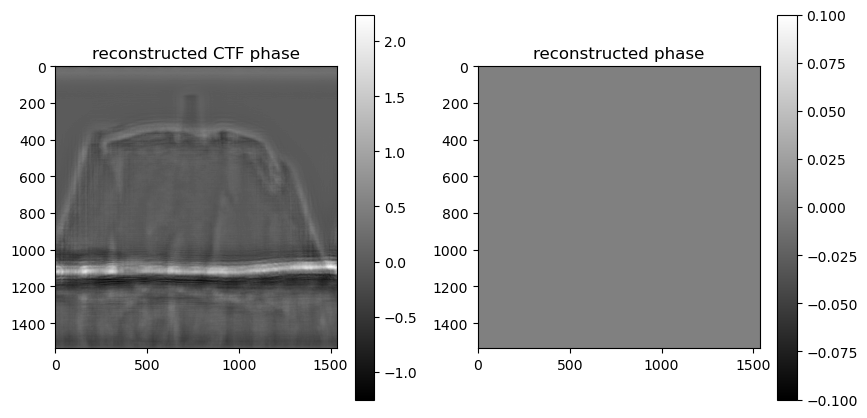

32) gammapsi=1 gammaprb=1, err=1.61032e+06


KeyboardInterrupt: 

In [16]:

pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 


rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = rref[:,np.newaxis]
print(data_ref.shape)
shifts_ref = np.array(shifts)[:,:1]*0
_,rec_prb0 = cg_holo_batch2(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 256, shifts_ref,shifts_probe, False,True,32,129,1,1)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
    axs[0].set_title('reconstructed amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0])-np.abs(rec_prb0[-1]),cmap='gray')
    axs[0].set_title('reconstructed amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0])-np.angle(rec_prb0[-1]),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)


In [ ]:
shifts_rec = np.array(shifts)
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')
rec = np.pad(recCTFPurePhase,((0,0),(n//2,n//2),(n//2,n//2)),'edge')
# use only the abs value of the probe as initial guess
rec_prb[:] = rec_prb0
rec,rec_prb = cg_holo_batch2(pslv, pslv0, data, data_ref, rec, rec_prb, niter, shifts_rec,shifts_probe, True,True,iter_step,iter_step,1,2)